# Corporate Decarbonization Research
Version: May 4th, 2024

---

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

### Table of Contents

**[Section 1) Loading and Cleaning](#section-1-loading-and-cleaning)**
- Loading the Raw Data
- Helper Functions
- More Data Cleaning

**[Section 2) EDA and Summary Statistics](#section-2-eda-and-summary-statistics)**
- Data Dictionary
- Cross-sector EDA

**[Section 3) Visualizations](#section-3-visualizations)**
- CDP Submissions
- Trends by Sector Charts
- Scatter Plots
- Company Emissions Charts
- Net-Zero Charts

**[Section 4) Correlation Analysis](#section-4-correlation-analysis)**

**[Section 5) Conclusion](#section-5-conclusion)**
- What we learned
- Next Steps
- Collaboration efforts

---

# SECTION 1) Loading and Cleaning

## Loading the Raw Data

*In this section of the notebook, I will be importing our data and performing some preliminary cleaning/standardizing of our datasets to create separate DataFrames for each sector and an aggregated DataFrame containing all sectors. More data cleaning will be performed after the **Helper Functions** section.*

In [3]:
# load in data

food = pd.read_csv('data/food.csv')
energy = pd.read_csv('data/energy.csv')
auto = pd.read_csv('data/auto.csv')
tech = pd.read_csv('data/tech.csv')


In [4]:
# Add sector columns to concatenate df's

food['SECTOR'] = ['Food & Agriculture'] * len(food['COMPANY NAME'])
energy['SECTOR'] = ['Energy'] * len(energy['COMPANY NAME'])
auto['SECTOR'] = ['Auto'] * len(auto['COMPANY NAME'])
tech['SECTOR'] = ['Tech'] * len(tech['COMPANY NAME'])
food.shape, energy.shape, auto.shape, tech.shape


((45, 15), (65, 15), (72, 16), (35, 15))

In [5]:
# clean tech to standardize columns across all df's, shorten CI column name

tech = tech.rename(columns={'CARBON INTENSITY\n(Scope 1 & 2 g CO2e/ $ Sales) \ncalculated' :
'CARBON INTENSITY\n(Scope 1 & 2 g CO2e / $ Sales)'})

df_array = [food, energy, auto, tech]
for df in df_array:
    df.rename(columns={'CARBON INTENSITY\n(Scope 1 & 2 g CO2e / $ Sales)': 'CARBON INTENSITY'}, inplace=True)


In [6]:
# concatenate dataframes together

sectors = pd.concat([food, energy, auto, tech])
sectors = sectors.drop(columns='SCOPE 1 + SCOPE 2 EMISSIONS')
sectors.shape

(217, 15)

### *To access a dataset containing all sectors, use the `sectors` DataFrame. To acccess individual sectors, choose from `foodag`, `tech`, `auto`, and `energy`.*

### `sectors`

In [7]:
# show sectors

sectors.head()

,COMPANY NAME,YEAR,SCOPE 1,SCOPE 2 (location-based),SCOPE 2 (market-based),SCOPE 3,TOTAL EMISSIONS,TOTAL REVENUE (miillion $),CURRENCY,CARBON INTENSITY,COUNTRY OF ORIGIN,SUBMIT TO CDP,GROWTH RATE,COMPANY SIZE,SECTOR
0,Anheuser-Busch InBev,2018,3700760.0,2383505.0,2059760,24431839.0,30516104.0,54619.0,USD,111.39,Belgium,Yes,NaN,NaN,Food & Agriculture
1,Anheuser-Busch InBev,2019,3600710.0,2215902.0,1761444,26484447.0,32301059.0,52329.0,USD,111.15,Belgium,Yes,-4.19,NaN,Food & Agriculture
2,Anheuser-Busch InBev,2020,3081905.0,2227758.0,1633815,23652933.0,28962596.0,46881.0,USD,113.26,Belgium,Yes,-10.41,NaN,Food & Agriculture
3,Anheuser-Busch InBev,2021,2953896.0,2243990.0,1456823,26527444.0,31725330.0,54304.0,USD,95.72,Belgium,Yes,15.83,NaN,Food & Agriculture
4,Anheuser-Busch InBev,2022,2843883.0,2029211.0,826257,24136111.0,29009205.0,57786.0,USD,84.33,Belgium,Yes,6.41,NaN,Food & Agriculture


### Example Sector DataFrame: `foodag`

In [8]:
# show food and ag

food.head()

,COMPANY NAME,YEAR,SCOPE 1,SCOPE 2 (location-based),SCOPE 2 (market-based),SCOPE 3,TOTAL EMISSIONS,TOTAL REVENUE (miillion $),CURRENCY,CARBON INTENSITY,COUNTRY OF ORIGIN,SUBMIT TO CDP,GROWTH RATE,COMPANY SIZE,SECTOR
0,Anheuser-Busch InBev,2018,3700760,2383505,2059760,24431839,30516104,54619,USD,111.39,Belgium,Yes,NaN,NaN,Food & Agriculture
1,Anheuser-Busch InBev,2019,3600710,2215902,1761444,26484447,32301059,52329,USD,111.15,Belgium,Yes,-4.19,NaN,Food & Agriculture
2,Anheuser-Busch InBev,2020,3081905,2227758,1633815,23652933,28962596,46881,USD,113.26,Belgium,Yes,-10.41,NaN,Food & Agriculture
3,Anheuser-Busch InBev,2021,2953896,2243990,1456823,26527444,31725330,54304,USD,95.72,Belgium,Yes,15.83,NaN,Food & Agriculture
4,Anheuser-Busch InBev,2022,2843883,2029211,826257,24136111,29009205,57786,USD,84.33,Belgium,Yes,6.41,NaN,Food & Agriculture


---

## Helper Functions

*This section will contain any functions used to generate graphs, standardize columns, etc.*

In [9]:
# convert revenue's to USD

def toUSD(i):
    dic = {
    'AUD': 0.75,   # 1 AUD to USD
    'CAD': 0.78,   # 1 CAD to USD
    'CHF': 1.09,   # 1 CHF to USD
    'DKK': 0.15,   # 1 DKK to USD
    'EUR': 1.16,   # 1 EUR to USD
    'GBP': 1.37,   # 1 GBP to USD
    'JPY': 0.009,  # 1 JPY to USD
    'KRW': 0.0009, # 1 KRW to USD
    'NOK': 0.11,   # 1 NOK to USD
    'RUB': 0.014,  # 1 RUB to USD
    'SEK': 0.11,   # 1 SEK to USD
    'RMB': 7.29,   # 1 RMB to USD
    'TWD' : 0.03,  # 1 TWD to USD
    'USD': 1.0       # No Change    
    }
    if (not pd.isna(i[0])) or (not pd.isna(i[1])):
        return i[0] * dic[i[1]] # The revenue multiplied by the corresponding USD conversion rate

# sectors['Revenue (USD)'] = sectors.apply(toUSD, 'TOTAL REVENUE (miillion $)')  # --- use this code to apply the function in the revenue column when ready

In [10]:
# Function for creating column with [Currency, Revenue]

def currAndRev(df):
    new_col = []
    for i in np.arange(df.shape[0]):
        new_col.append([df['CURRENCY'].values[i], df['TOTAL REVENUE (miillion $)'].values[i]])
    df['REVENUE IN USD'] = new_col


In [38]:
# graph sector summary charts using matplotlib

def graphCoEmissions(df, co_name, years_arr):
    # format plots and add right axis for CI
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    # create x axis array
    years = df.loc[df['COMPANY NAME']==co_name, 'YEAR']

    # create bar chart stacks and CI array
    scope1 = df.loc[df['COMPANY NAME']==co_name, 'SCOPE 1']
    scope2 = df.loc[df['COMPANY NAME']==co_name, 'SCOPE 2 (location-based)']
    scope3 = df.loc[df['COMPANY NAME']==co_name, 'SCOPE 3']
    ci = df.loc[df['COMPANY NAME']==co_name, 'CARBON INTENSITY']

    # plot bar chart
    b1 = ax1.bar(years, np.log(scope1), color='navy', label='Scope 1')
    b2 = ax1.bar(years, np.log(scope2), bottom=np.log(scope1), color='steelblue', label='Scope 2')
    b3 = ax1.bar(years, np.log(scope3), bottom=np.log(scope1)+np.log(scope2), color='lightsteelblue', label='Scope 3')

    # plot CI
    l1 = ax2.plot(years, np.log(ci), color = 'black', marker = 'o',label='CI')

    # finish formatting plots
    ax1.set_xticks(years_arr)
    # ax1.set_ylim(0, max(scope1+scope2+scope3)+9000000)
    ax2.set_ylim(0, 5)

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='lower center', bbox_to_anchor=(0.5, -0.25), fancybox=True, shadow=True, ncol=4)

    # add labels and titles
    plt.suptitle('Annual GHG Emissions', fontsize=16, fontweight='bold')
    plt.title(co_name, fontsize=12)
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Natural Log of Carbon Emissions (mt CO2e)')
    ax2.set_ylabel('Natural Log of Carbon Intensity (mt CO2e / mill USD)')

In [12]:
# graph sector summary charts using plotly
import plotly.graph_objects as go

def graphCoEmissionsPlotly(df, co_name, years_arr):
    # format plots and add right axis for CI
    # fig, ax1 = plt.subplots()
    # ax2 = ax1.twinx()

    # create x axis array
    years = df.loc[df['COMPANY NAME']==co_name, 'YEAR']

    # create bar chart stacks and CI array
    scope1 = df.loc[df['COMPANY NAME']==co_name, 'SCOPE 1']
    scope2 = df.loc[df['COMPANY NAME']==co_name, 'SCOPE 2 (location-based)']
    scope3 = df.loc[df['COMPANY NAME']==co_name, 'SCOPE 3']
    ci = df.loc[df['COMPANY NAME']==co_name, 'CARBON INTENSITY']


     # create stacked bar chart traces
    trace_scope1 = go.Bar(x=years, y=scope1, name='Scope 1', marker=dict(color='rgba(0, 0, 255, 0.7)'))
    trace_scope2 = go.Bar(x=years, y=scope2, name='Scope 2', marker=dict(color='rgba(0, 255, 0, 0.7)'))
    trace_scope3 = go.Bar(x=years, y=scope3, name='Scope 3', marker=dict(color='rgba(255, 0, 0, 0.7)'))

    # create line chart trace for CI
    trace_ci = go.Scatter(x=years, y=ci, mode='markers+lines', name='Carbon Intensity', yaxis='y2',
                          marker=dict(color='rgba(255, 165, 0, 0.7)'))

    # combine traces into data list
    data = [trace_scope1, trace_scope2, trace_scope3, trace_ci]

    # create layout
    layout = go.Layout(
        title=dict(text=co_name+' - Annual GHG Emissions', x=0.5),
        xaxis=dict(tickvals=years_arr, title='Year'),
        yaxis=dict(title='Carbon Emissions (metric ton CO2e)', range=[0, max(scope1+scope2+scope3)+9000000]),
        yaxis2=dict(title='Carbon Intensity (g CO2e / $ million)', overlaying='y', side='right', range=[0, max(ci)+20]),
        barmode='stack',
        showlegend=True,
        height=650,
        width=800,
        margin=dict(r=1.2)
    )

    # create figure
    fig = go.Figure(data=data, layout=layout)

    # show the figure
    fig.show()

In [13]:
# graph sector totals by company and emissions type

def graph_CosInSectorTotals(df, year, bool=False):
    # define the sector
    sector = df['SECTOR'].unique()[0]

    # filer DataFrame for just the provided year
    data_year = df.loc[df['YEAR']==year,:]

    # plot stacked bar chart
    sns.barplot(x='SCOPE 1', y='COMPANY NAME', data=data_year, color='orange', orient='h', label='Scope 1')
    sns.barplot(x='SCOPE 2 (location-based)', y='COMPANY NAME', data=data_year, color='navy', orient='h', label='Scope 2')
    if bool==False:
        sns.barplot(x='SCOPE 3', y='COMPANY NAME', data=data_year, color='pink', orient='h', label='Scope 3')
    
    # format axes and titles
    plt.xlabel('GHG emissions (metric tons CO2e)')
    plt.ylabel('Company Name')
    if bool==True:
        plt.title('Scope 1 + Scope 2 GHG Emissions in '+str(year)+' - ' +str(sector))
    else:
        plt.title('Total GHG Emissions in '+str(year)+' - ' +str(sector))

In [14]:
sectors['Adjusted CI'].isna().sum()

KeyError: 'Adjusted CI'

In [70]:
# graph carbon intensity as a function of time of each company in a sector using natural log of adjusted CI values

def ci_OverTime(sector):

    companies = sectors.loc[sectors['SECTOR']==sector, 'COMPANY NAME'].unique()
    years = ['2018','2019', '2020', '2021', '2022']

    for co in companies:
        ci = sectors[sectors['COMPANY NAME'] == co]["Adjusted CI"]
        if ci.isna().sum()==0:
            plt.plot(years, np.log(ci), label = co, marker='o', markersize=5)
        plt.legend(loc = 'upper right', fontsize = 'xx-small')
        plt.xlabel('Year')
        plt.ylabel('Carbon Intensity (mt $CO_{2}e$ / mill USD)')
        plt.suptitle('Natural Log of Carbon Intensity (2018-2022)', fontweight='bold')
        plt.title(sector, fontsize=12)  

---

## More Data Cleaning

*In this section, I am performing the data cleaning which require my **helper functions** to execute.* Make sure that the previous section has been run before proceeding.

In [22]:
# apply and create revenue in USD column

rev_curr = [[sectors['TOTAL REVENUE (miillion $)'].values[i], sectors['CURRENCY'].values[i]] for i in range(sectors.shape[0])]
sectors['REVENUE W/ CURR'] = rev_curr

# create revenue in USD column and drop revenue w/ curr column

sectors['REVENUE IN USD'] = sectors['REVENUE W/ CURR'].apply(toUSD)
sectors = sectors.drop(columns='REVENUE W/ CURR')

In [23]:
# creating adjusted CI column after converting ALL revenues to USD

adjusted_ci = ((sectors['SCOPE 1'] + sectors['SCOPE 2 (location-based)']) / sectors['REVENUE IN USD']).round(2)
sectors['Adjusted CI'] = adjusted_ci

In [24]:
# Replace 'Submit to CDP' & 'SBTi Target Set?' values with True and False for performing qualitative data analysis

sectors['SUBMIT TO CDP'] = sectors['SUBMIT TO CDP'].replace({
    'Yes' : True,
    'No' : False
})

In [25]:
# creates a separate csv file of sectors data
load_sectors = sectors.to_csv('data/sectors.csv', index=False)
load_sectors

---

# SECTION 2) EDA and Summary Statistics

## Data Dictionary

| COLUMN NAME | DEFINITION | DATA TYPE |
|--------------|:-----:|-----------:|
| Company Name | Name of the company | object |
| Year | Corresponding year of emissions data | int |
| Scope 1 | The company's direct GHG emissions, given in metric tons of carbon dioxide equivalence | float |
| Scope 2 (location-based) | The company's indirect (location-based) GHG emissions, given in metric tons of carbon dioxide equivalence | float |
| Scope 3 | The company's indirect GHG emissions that come from its value chain, given in metric tons of carbon dioxide equivalence | float |
| Total Emissions | Sum of Scope 1, 2, and 3 emissions | float |
| Total Revenue (million $) | The company's total revenue for a given fiscal year | float |
| Currency | The currency of the company's total revenue | object |
| Carbon Intensity | Total scope 1 and scope 2 (location-based) emissions per unit of the company's revenue | float |
| Country of Origin | The company's origin country | object |
| Submit to CDP | Boolean indicator of if the company submitted to CDP for the reporting year (True/False) | object |
| Growth Rate | The percent change of as a function of a company's total revenue, calculated by taking the difference between total revenues from two fiscal years and dividing by the initial year's revenue | float
| Company Size | ... | ... |
| Sector | The industry sector of the company | object |
| Revenue in USD | A company's total revenue represented in USD based on an exchange rate | float |
| Adjusted CI | Total scope 1 and scope 2 (location-based) emissions per US dollar | float |



## Cross-Sector Exploratory Data Analysis (EDA)

*This section is dedicated to data analysis through visualizations and observing general trends in the data across sectors.*

### Looking at average scope, average total emissions, average, total revenue, and average CI by sector.

The GroupBy object created below, sorted in descending order by `TOTAL EMISSIONS`, shows us that **energy** is the highest-emitting sector while **tech** comes last out of our four sectors.

In [26]:
# Average scope values by sector in descending order of average total emissions

avg_emissions = sectors.groupby('SECTOR').mean(numeric_only=True).round(0).sort_values(by='TOTAL EMISSIONS', ascending=False)[['SCOPE 1', 'SCOPE 2 (location-based)', 'SCOPE 3',  'TOTAL EMISSIONS']]
avg_emissions

,SCOPE 1,SCOPE 2 (location-based),SCOPE 3,TOTAL EMISSIONS
SECTOR,,,,
Energy,49000779.0,7866270.0,425962254.0,387097297.0
Auto,1364395.0,2825630.0,223338879.0,229577835.0
Food & Agriculture,1546647.0,1181952.0,39522984.0,42730673.0
Tech,2482006.0,5799836.0,27005205.0,38307379.0


In [27]:
# Average Corporate Revenues converted to USD

avg_ci = sectors.groupby('SECTOR').mean(numeric_only=True).sort_values(by='REVENUE IN USD', ascending=False).round(0)[['REVENUE IN USD']]
avg_ci

,REVENUE IN USD
SECTOR,
Tech,210002.0
Energy,131235.0
Auto,129654.0
Food & Agriculture,49361.0


### A rough look at highest-emitting companies on average

This GroupBy object shows us the highest-emitting companies on average, sorted by average `TOTAL EMISSIONS`. 

*NOTE: This is not a completely reflective ranking because it doesn't take into account the companies that don't report certain scope values (indicated by NaN).*

In [28]:
sectors.groupby('COMPANY NAME').mean(numeric_only=True).drop(columns=['YEAR']).sort_values(by='TOTAL EMISSIONS', ascending=False)

,SCOPE 1,SCOPE 2 (location-based),SCOPE 3,TOTAL EMISSIONS,TOTAL REVENUE (miillion $),CARBON INTENSITY,GROWTH RATE,COMPANY SIZE,REVENUE IN USD,Adjusted CI
COMPANY NAME,,,,,,,,,,
Shell,6.300000e+07,1.000000e+07,1.056447e+09,1.138447e+09,3.181430e+05,249.320000,7.822500,NaN,318143.000000,249.320000
Chevron,5.840000e+07,3.400000e+06,1.028200e+09,1.093400e+09,1.569122e+05,427.920000,17.937500,NaN,156912.200000,427.920000
Gazprom,8.822895e+07,5.827761e+06,1.127929e+09,7.708143e+08,3.554709e+06,NaN,-15.485000,NaN,49765.926000,2421.040000
Toyota,2.272571e+06,4.357166e+06,4.167293e+08,4.256259e+08,2.084658e+05,31.988333,2.918000,NaN,1876.192500,3554.291667
Volkswagen,4.399641e+06,5.558314e+06,3.906809e+08,4.040267e+08,2.546363e+05,39.433333,5.764000,NaN,295378.146667,33.993333
BP,4.066000e+07,3.760000e+06,3.437250e+08,3.230600e+08,2.217036e+05,226.910000,8.440000,NaN,221703.600000,226.910000
Honda,1.223374e+06,3.410813e+06,2.879159e+08,2.960877e+08,1.513838e+07,0.306667,2.406000,NaN,136245.450000,34.126667
Equinor,1.326715e+07,1.653358e+05,2.762498e+08,2.923918e+08,8.629960e+04,185.380000,29.090000,NaN,86299.600000,185.380000
Fiat-Chrysler,1.227754e+06,2.414369e+06,2.668018e+08,2.729287e+08,1.365630e+05,27.941667,14.020000,NaN,158413.080000,24.088333


### Average Emissions by Country of Origin

Now let's take a look at the average emissions by country of origin, still sorting by average `TOTAL EMISSIONS` in descending order.

*NOTE: I am still working on figuring out how to differentate companies with more than one country of origin.*

In [29]:
avg_ByCountry = sectors.groupby('COUNTRY OF ORIGIN').mean(numeric_only=True).drop(columns=['YEAR', 'TOTAL REVENUE (miillion $)']).round(0).sort_values(by='TOTAL EMISSIONS', ascending=False)
avg_ByCountry

,SCOPE 1,SCOPE 2 (location-based),SCOPE 3,TOTAL EMISSIONS,CARBON INTENSITY,GROWTH RATE,COMPANY SIZE,REVENUE IN USD,Adjusted CI
COUNTRY OF ORIGIN,,,,,,,,,
"United Kingdom, Netherlands",63000000.0,10000000.0,1.056447e+09,1.138447e+09,249.0,8.0,NaN,318143.0,249.0
Russsia,74482749.0,12415423.0,7.015146e+08,7.708143e+08,NaN,-15.0,NaN,49766.0,2421.0
Japan,1747972.0,3883990.0,3.523226e+08,3.608568e+08,16.0,3.0,NaN,69061.0,1794.0
United Kingdom,40660000.0,3760000.0,3.437250e+08,3.230600e+08,227.0,8.0,NaN,221704.0,227.0
Norway,13267146.0,165336.0,2.762498e+08,2.923918e+08,185.0,29.0,NaN,86300.0,185.0
"Italy, United States",1227754.0,2414369.0,2.668018e+08,2.729287e+08,28.0,14.0,NaN,158413.0,24.0
Germany,2017265.0,2838729.0,2.017792e+08,2.082136e+08,25.0,4.0,NaN,205322.0,21.0
United States,15087459.0,3682030.0,1.773647e+08,1.870961e+08,170.0,16.0,NaN,152063.0,172.0
China,38689365.0,13877112.0,9.032162e+07,1.292112e+08,2588.0,24.0,NaN,147268.0,430.0


The first row corresponds to **Shell**, last row corresponds to **Molson Coors**.

---

# SECTION 3) Visualizations

### CDP Submission: Who Reported to CDP?

The purpose of this section is to view the proportion of companies across all sectors who reported to CDP.

In [30]:
# Proportion of CDP submissions over number of reports

submission_percentage = (sum(sectors['SUBMIT TO CDP'] == True) / sectors.shape[0]) * 100

print('Across all sectors, ' + str(round(submission_percentage,0))+ '% of companies submitted to cdp')

Across all sectors, 70.0% of companies submitted to cdp


Now we know 70% of our data comes from CDP submissions. To compare CDP submissions per sector visually, I created a **count plot** using `sectors`.

Text(0.5, 1.0, 'Count of CDP Submissions by Sector')

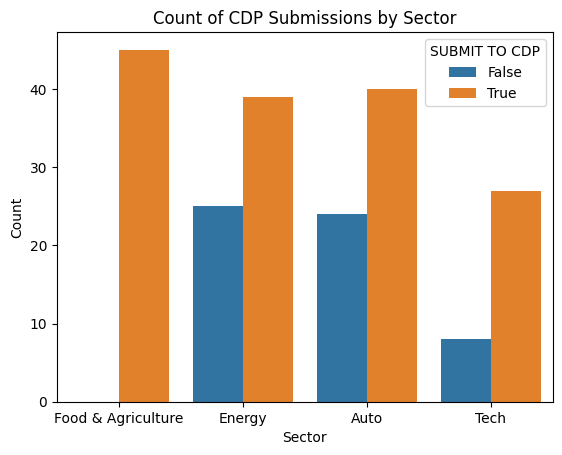

In [31]:
# Plot counts of submissions

sns.countplot(x='SECTOR', hue='SUBMIT TO CDP', data=sectors)
plt.xlabel('Sector')
plt.ylabel('Count')
plt.title('Count of CDP Submissions by Sector')

### CDP Submissions: How do submission trends look over time?

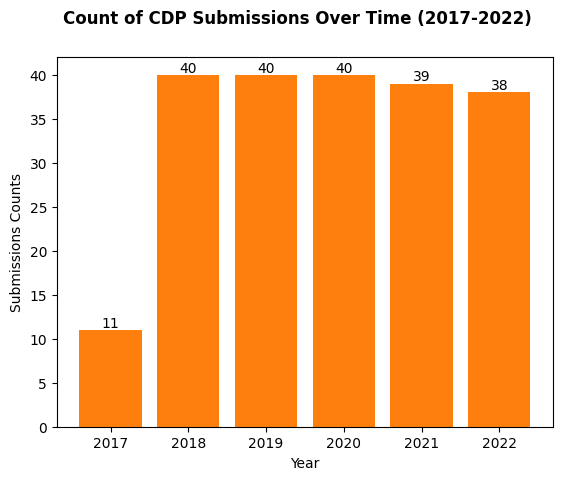

In [32]:
# Visualizing CDP Submissions Over TIme

x = np.arange(2017,2023)
y = sectors.groupby('YEAR').count()['SUBMIT TO CDP']

fig, ax = plt.subplots()
plt.bar(x, y)
plt.suptitle('Count of CDP Submissions Over Time (2017-2022)', fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Submissions Counts')
bars = ax.bar(x, y)
ax.bar_label(bars)
plt.show();

---

## Sector Charts 

*The goal of this section is to ...*

### $\ln$(Carbon Intensity) Over Time by Sector

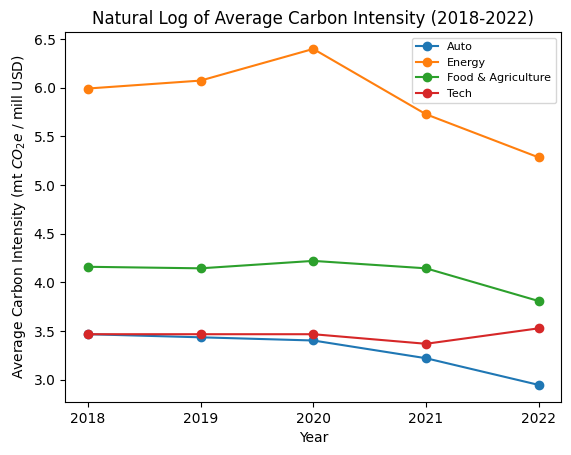

In [47]:
avgci_BySector = sectors.pivot_table(
    index='YEAR',
    columns='SECTOR',
    values='Adjusted CI',
    aggfunc = np.median
).round(0).reset_index().drop([0])


for sector in avgci_BySector.columns[1:]:
    plt.plot(avgci_BySector['YEAR'], np.log(avgci_BySector[sector]), label=sector, marker='o')

plt.xticks(np.linspace(2018, 2022,5))
plt.title('Natural Log of Average Carbon Intensity (2018-2022)')
plt.ylabel('Average Carbon Intensity (mt $CO_{2}e$ / mill USD)')
plt.xlabel('Year')
plt.legend(fontsize=8)
plt.show(); 

### A Closer Look of CI Over Time by Sector

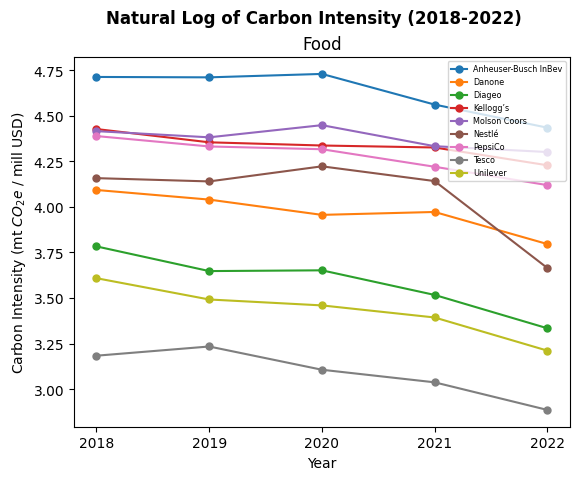

In [61]:
# Food & Ag
ci_OverTime('Food & Agriculture')

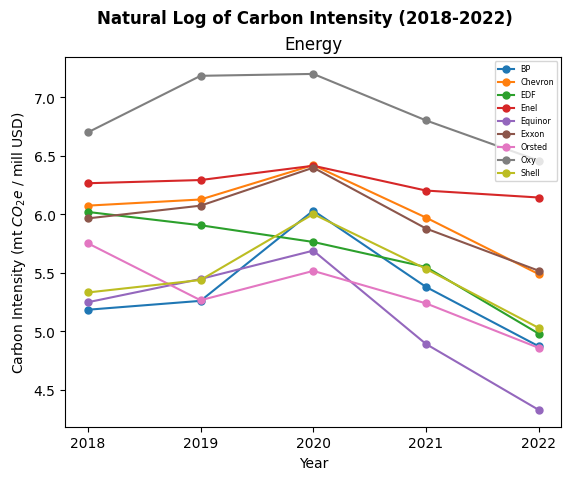

In [57]:
# Energy
ci_OverTime('Energy')

In [58]:
np.log(sectors[sectors['COMPANY NAME']=='Apple']['Adjusted CI'])

10   -1.386294
11    1.258461
12    1.229641
13    0.947789
14    1.043804
Name: Adjusted CI, dtype: float64

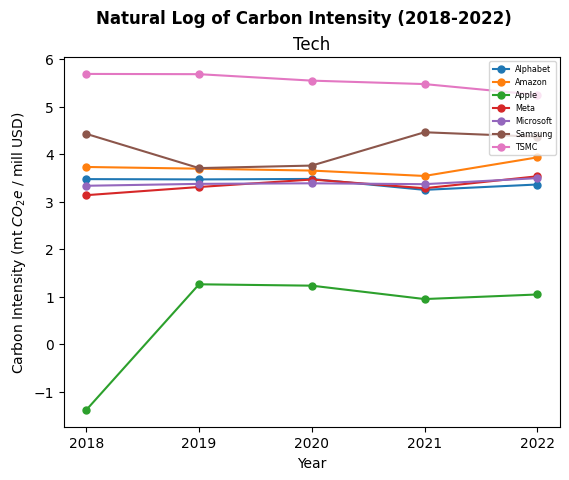

In [59]:
# Tech
ci_OverTime('Tech')

<span style="color:red">TASK: Debug auto (function won't work for auto sector).</span>

In [67]:
sectors = sectors[sectors['YEAR']!=2017]

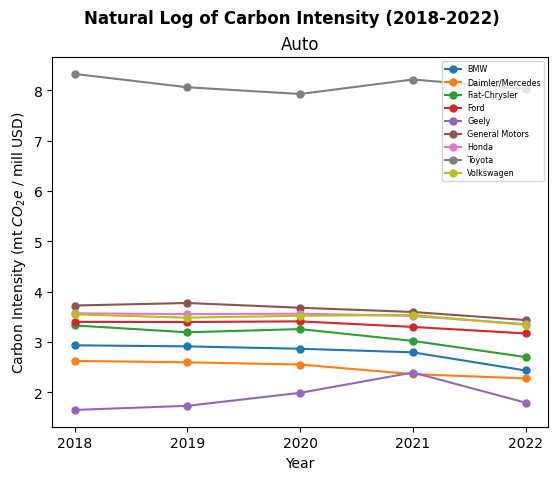

In [71]:
# Auto
ci_OverTime('Auto')

### Total GHG Emissions Over Time by Sector

In [ ]:
energy_totals = energy.groupby('YEAR').sum(numeric_only=True)
energy_totals['TOTAL EMISSIONS']

years=[2018,2019,2020,2021,2022]
total_emissions = energy_totals['TOTAL EMISSIONS'].values / 1000000

fig, ax = plt.subplots()

ax.bar(years, total_emissions, color='navy')
plt.xlabel('Year')
plt.ylabel('GHG Emissions (million mt $CO_{2}e$)')
plt.title('Energy Sector', fontsize=10)
plt.suptitle('Total GHG Emissions (2018-2022)', fontsize=14, fontweight='bold')
bars = ax.bar(years, total_emissions)
ax.bar_label(bars)
plt.show();

---

## Company Charts by Sector

*The charts generated below follow the format of the charts we generated in Google Sheets. Make sure to run the **Helper Functions** section in order to generate this section properly.*

### Food & Agriculture Emissions Charts

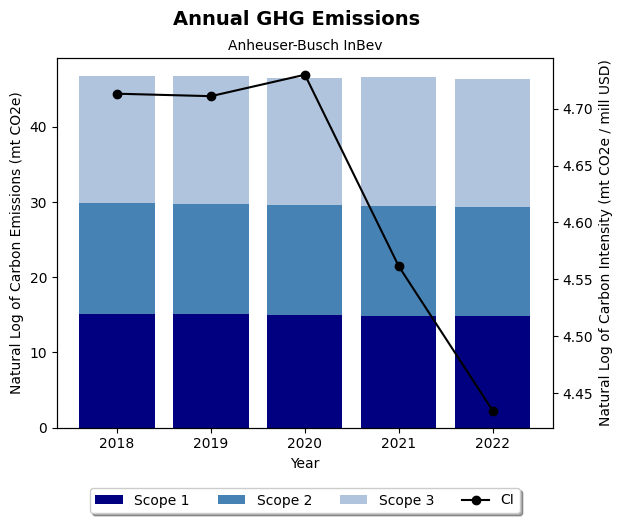

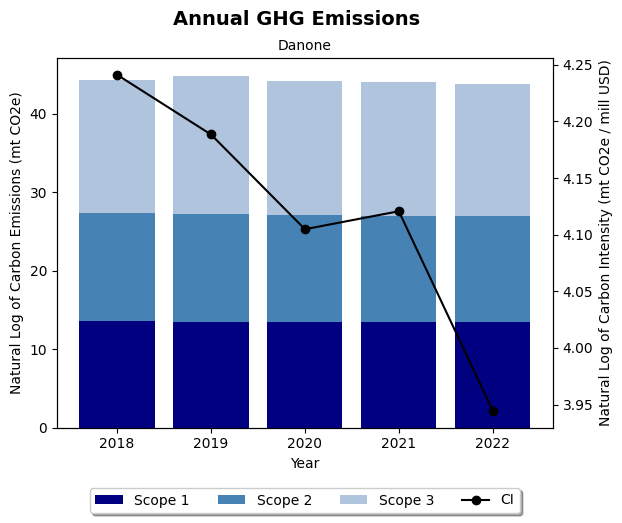

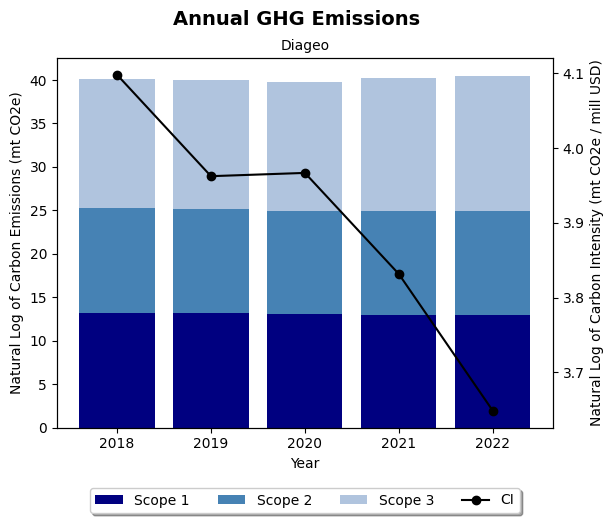

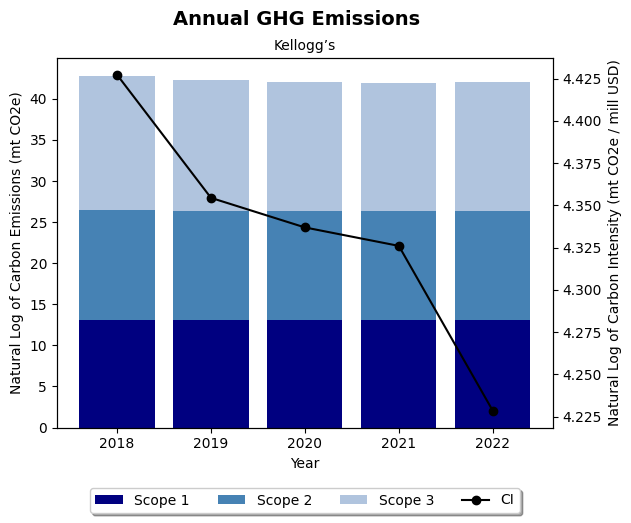

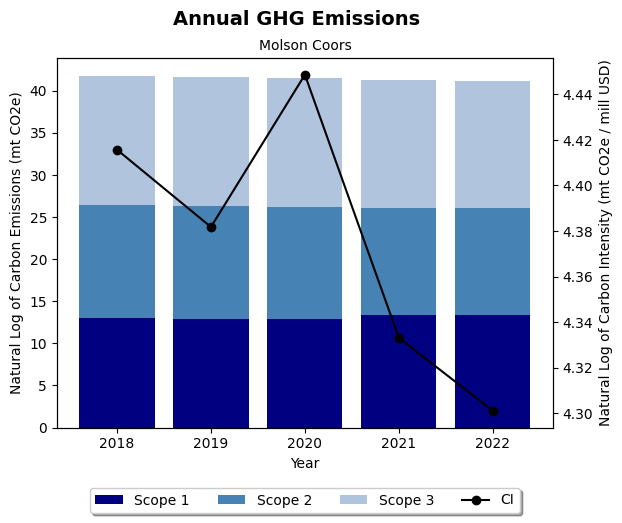

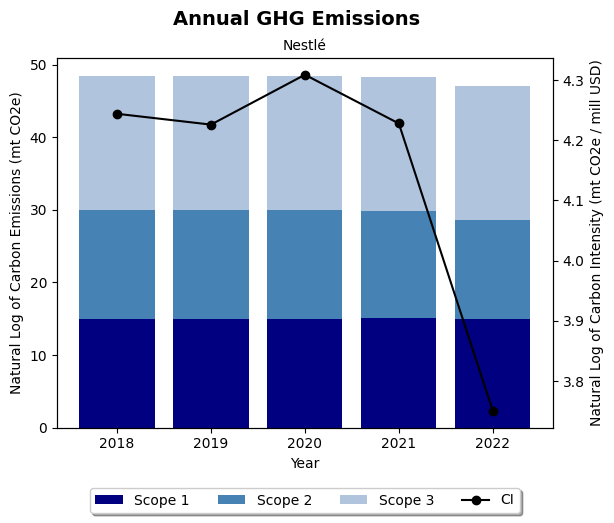

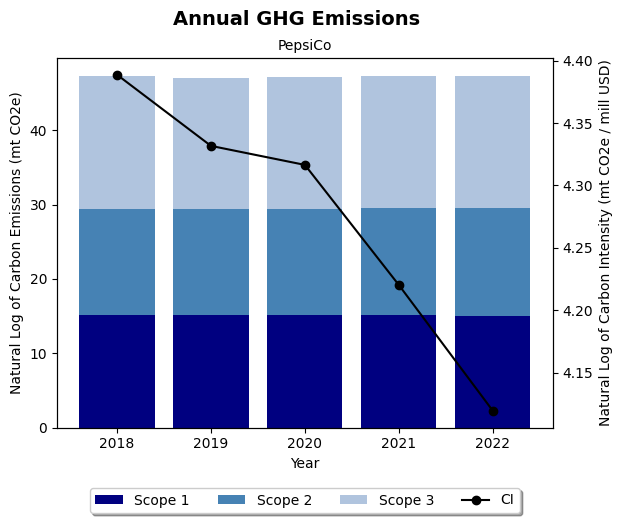

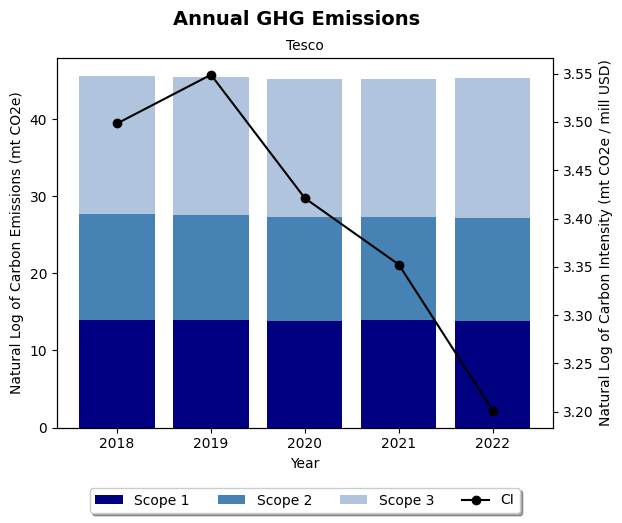

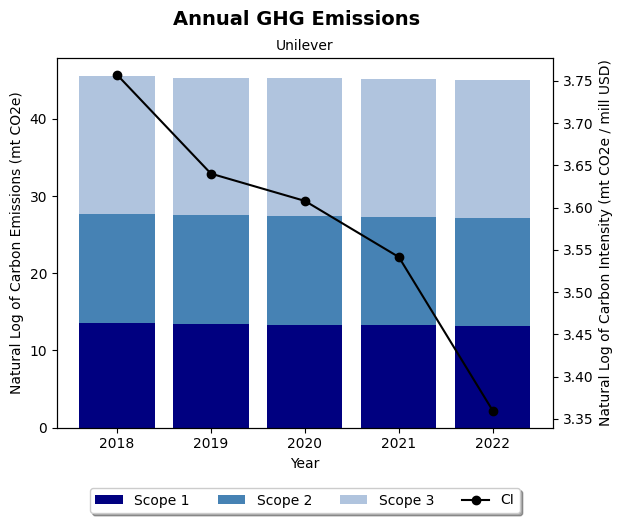

In [18]:
# graph charts for every company

yrs1 = [2017, 2018, 2019, 2020]
yrs2 = [2018, 2019, 2020, 2021]
yrs3 = [2018, 2019, 2020, 2021, 2022]
yrs4 = [np.arange(2017, 2023)]

for company in food['COMPANY NAME'].unique():
    num_years = food.loc[food['COMPANY NAME']==company, 'YEAR'].shape[0]
    if num_years == 4:
        graphCoEmissions(food, company, yrs2)
    else:
        graphCoEmissions(food, company, yrs3)

In [19]:
# another way to plot charts
# import plotly.graph_objects as go

# for company in foodag['COMPANY NAME'].unique():
#     num_years = foodag.loc[foodag['COMPANY NAME']==company, 'YEAR'].shape[0]
#     if num_years == 4:
#         graphCoEmissionsPlotly(foodag, company, yrs2)
#     else:
#         graphCoEmissionsPlotly(foodag, company, yrs3)


### Energy Emissions Charts

<span style="color:red">TASK: Exclude years with no data.</span>

In [ ]:
# graph energy charts

for company in energy['COMPANY NAME'].unique():
    num_years = energy.loc[energy['COMPANY NAME']==company, 'YEAR'].shape[0]
    if num_years == 4:
        graphCoEmissionsPlotly(energy, company, yrs2)
    else:
        graphCoEmissionsPlotly(energy, company, yrs3)

### Tech Emissions Charts

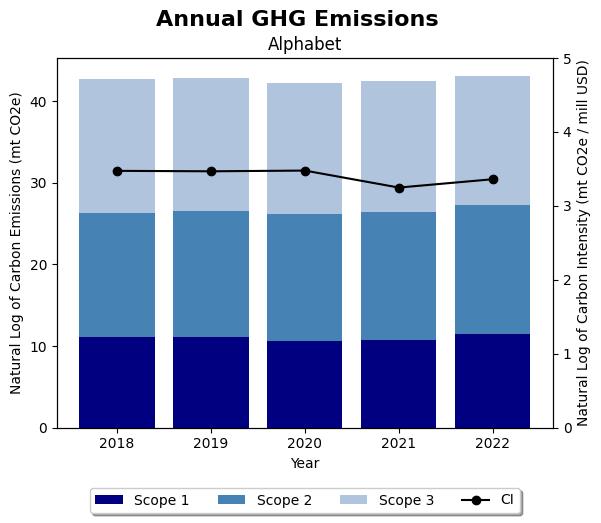

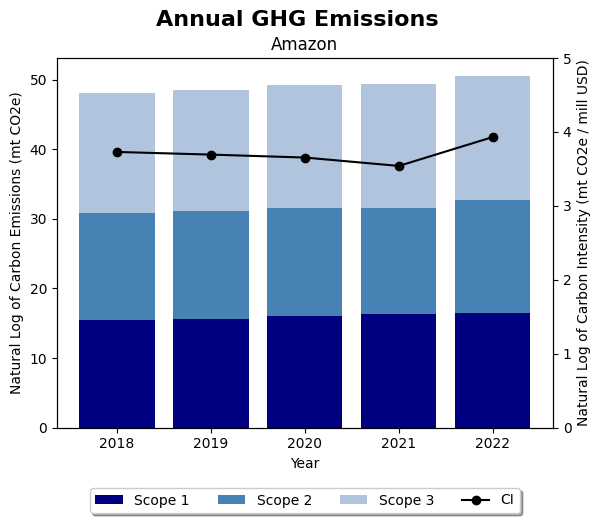

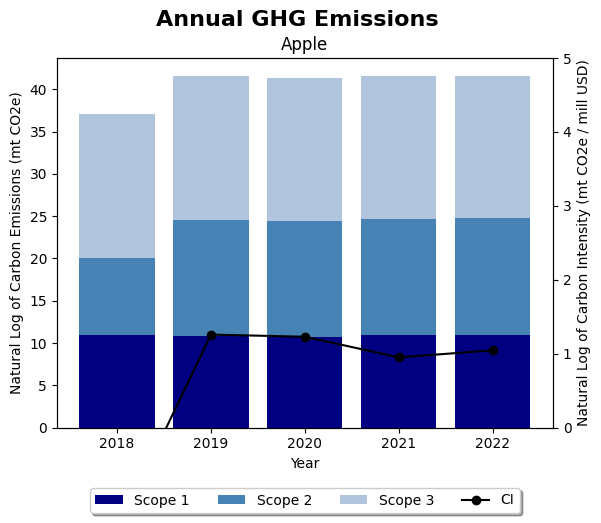

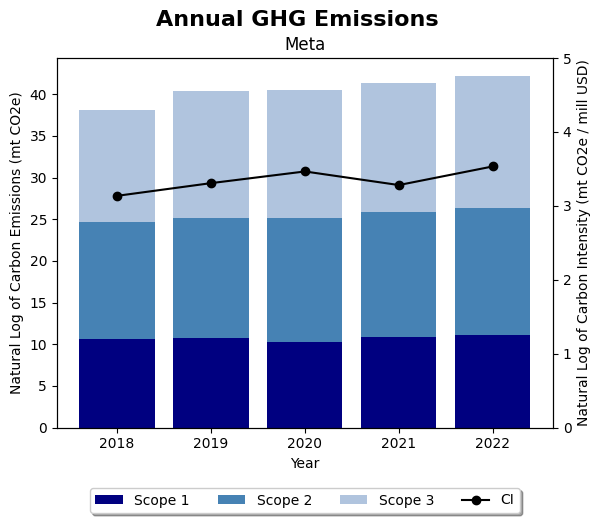

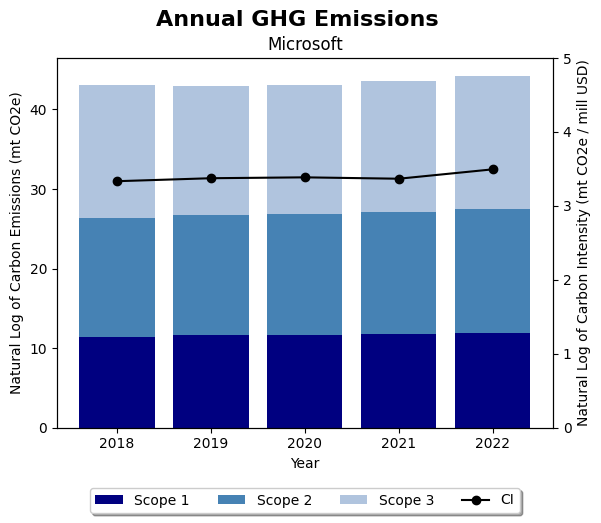

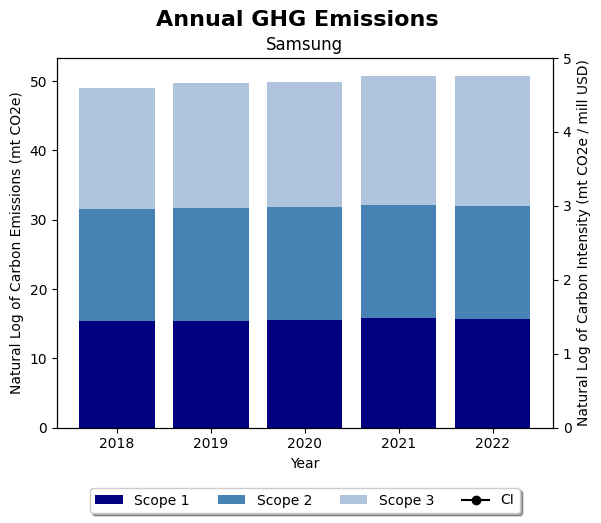

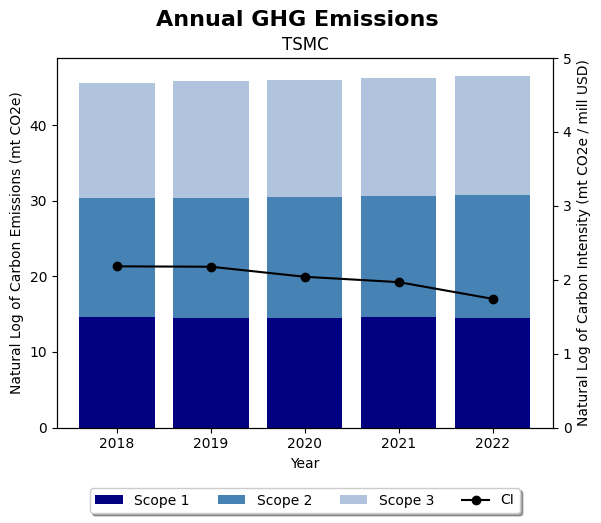

In [39]:
# graph tech charts

for company in tech['COMPANY NAME'].unique():
    num_years = tech.loc[tech['COMPANY NAME']==company, 'YEAR'].shape[0]
    if num_years == 4:
        graphCoEmissions(tech, company, yrs2)
    else:
        graphCoEmissions(tech, company, yrs3)

### Auto Emissions Charts

In [ ]:
for company in auto['COMPANY NAME'].unique():
    num_years = auto.loc[auto['COMPANY NAME']==company, 'YEAR'].shape[0]
    if num_years == 4:
        graphCoEmissionsPlotly(auto, company, yrs2)
    else:
        graphCoEmissionsPlotly(auto, company, yrs3)

---

## Net-Zero Goals & SBTI Committments

I'd like to create simple visuals depicting net-zero goals for each firm

In [ ]:
sbti_byco = sectors[sectors['YEAR']==2022][['COMPANY NAME', 'SBTI COMMITMENTS', 'SECTOR']]
sbti_byco['SBTI COMMITMENTS'].unique()

sbti_byco['SBTI COMMITMENTS'] = sbti_byco['SBTI COMMITMENTS'].replace(to_replace={
    '[Near-term targets set, net-zero committed]' : 'Near-term targets set, net-zero committed',
    '[Near-term targets set]' : 'Near-term targets set',
    '[Near-term targets set, net-zero targets set]' : 'Near-term targets set, net-zero targets set'
})

co = sbti_byco.groupby(['SBTI COMMITMENTS', 'SECTOR']).count().reset_index().sort_values(by='SECTOR')
co = co.rename(columns={'COMPANY NAME' : 'Counts'})

co

In [ ]:
sns.countplot(sbti_byco['SBTI COMMITMENTS'])
plt.xlabel('Number of Companies')
plt.ylabel('SBTI Status')
plt.title('SBTI Targets Status Across Firms')

plt.show()

---

# Section 4) Correlation Analysis

---

# Section 5) Conclusion

maybe link paper here?

## What We Learned


## Next Steps

## Collaboration Efforts

Contribute to our live database by filling out this Google Form and report your own emissions data!

---